# RF electrode in a microring modulator

The microring modulator (MRR) is a key component in modern photonics design. In this notebook, we model the RF electrode in a silicon-on-insulator MRR, which carries the electrical signal responsible for optical modulation.

In a full fidelity model, the MRR would require multiphysics coupling of thermal, charge, optical, and RF simulations. For this RF-only demonstration, we will approximate the reverse bias p-n junction, responsible for the optical phase modulation, with a lumped RC element. The focus will be on minimizing return loss within the operational bandwidth. 

<center><img src="img/mrr-electrode-render.png" width=640 /></center>

In [1]:
import gdstk
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.rf as rf
from tidy3d import web

td.config.logging.level = "ERROR"

## Building the Model

### Key Parameters and Materials

The bandwidth of the simulation is 10-100 GHz. 

In [2]:
# Frequency bandwidth
f_min, f_max = (10e9, 100e9)
f0 = (f_max + f_min) / 2
freqs = np.linspace(f_min, f_max, 101)

# Dimensions
len_inf = 1e5
bounds_electrode = (2.62, 3.02)
bounds_oxide = (-3.017, 2.62)
bounds_sub = (-len_inf, -3.017)
TM = bounds_electrode[1] - bounds_electrode[0]  # electrode thickness

The equivalent RC parameters of the reverse bias p-n junction can be estimated using a lumped circuit model. Details of the calculation are presented in section 2.2.3 of Ref [1]. 

In [3]:
# Lumped electrical parameters
C_lumped = 17.325e-15  # Farads
R_lumped = 113.12  # Ohms
Zref = 50  # Ohms, port reference impedance

The relevant materials are defined below.  

In [4]:
# Mediums
med_sub = td.Medium(permittivity=12.3)  # Si substrate
med_oxide = td.Medium(permittivity=4.2)  # SiO2
med_metal = rf.LossyMetalMedium(conductivity=17, frequency_range=(f_min, f_max))  # Metal [S/um]

### Geometry

In lieu of building the electrode geometry from scratch, we will import a pre-constructed 2D shape from GDS. It is then extruded to the appropriate thickness. For more details on working with GDS files, see this [tutorial](https://www.flexcompute.com/tidy3d/examples/notebooks/GDSImport/).

In [5]:
# Load GDS and build metal electrode geometry
gds_mmr = gdstk.read_gds("misc/mrr-electrode.gds")
g_electrode = td.Geometry.from_gds(
    gds_mmr["MRR"], gds_layer=12, gds_dtype=0, slab_bounds=bounds_electrode, axis=2
)

# Dielectric layers
g_oxide = td.Box.from_bounds(
    rmin=(-len_inf, -len_inf, bounds_oxide[0]), rmax=(len_inf, len_inf, bounds_oxide[1])
)
g_sub = td.Box.from_bounds(
    rmin=(-len_inf, -len_inf, bounds_sub[0]), rmax=(len_inf, len_inf, bounds_sub[1])
)

The geometries are combined with the corresponding mediums into `Structure` instances below.  

In [6]:
# Structures
str_sub = td.Structure(geometry=g_sub, medium=med_sub)
str_oxide = td.Structure(geometry=g_oxide, medium=med_oxide)
str_electrode = td.Structure(geometry=g_electrode, medium=med_metal)
structure_list = [str_sub, str_oxide, str_electrode]

### Grid and Boundary

The external boundaries of the simulation are terminated with Perfectly Matched Layers (PMLs) by default. We add some space padding around the electrode, although we do not expect it to radiate significantly.

In [7]:
# Simulation center and size
sim_X0, sim_Y0, sim_Z0 = (30, -30, 0)
sim_LX, sim_LY, sim_LZ = (450, 300, 400)

The grid should be able to resolve key features in the electrode, such as the gap and corners, for accurate results. To this end, we use the `LayerRefinementSpec` feature to automatically analyze the electrode geometry and generate an appropriately fine mesh. For added fidelity, we also define a `MeshOverrideStructure` around the microring region that constrains maximum grid size in the in-plane directions. 

In [8]:
# Layer refinement
lr1 = rf.LayerRefinementSpec.from_structures(
    structures=[str_electrode],
    corner_refinement=td.GridRefinement(dl=1, num_cells=2),
    min_steps_along_axis=1,
)

# Mesh override
refine_box = td.MeshOverrideStructure(
    geometry=td.Box.from_bounds(
        rmin=(16.5, 1, bounds_electrode[0]), rmax=(43.5, 27, bounds_electrode[1])
    ),
    dl=(1, 1, None),
)

The overall grid specification is defined below. The rest of the simulation grid is automatically generated based on the shortest wavelength. 

In [9]:
# Grid specification
grid_spec = td.GridSpec.auto(
    min_steps_per_wvl=12,
    wavelength=td.C_0 / f_max,
    layer_refinement_specs=[lr1],
    override_structures=[refine_box],
)

### Monitors

We define a field monitor just below the electrode plane for visualization purposes.  

In [10]:
# Field Monitor
mon_1 = td.FieldMonitor(
    center=(sim_X0, sim_Y0, bounds_electrode[0]),
    size=(len_inf, len_inf, 0),
    freqs=[f_min, f0, f_max],
    name="field in-plane",
)

monitor_list = [mon_1]

### Lumped Ports and Elements

We will use lumped ports and elements in this model since the structure is extremely sub-wavelength.

In [11]:
# Lumped port
LP1 = rf.LumpedPort(
    center=(30, -85, bounds_electrode[1]),
    size=(60, 10, 0),
    voltage_axis=1,
    name="LP1",
    impedance=Zref,
)

The equivalent RC circuit representing the p-n junction is defined below. 

In [12]:
# Lumped element (RC network)
lumped_network = rf.RLCNetwork(resistance=R_lumped, capacitance=C_lumped, network_topology="series")
LE1 = rf.LinearLumpedElement(
    center=(30, 24.795, bounds_electrode[1]),
    size=(2, 2.2, 0),
    voltage_axis=1,
    network=lumped_network,
    name="LumpedRC",
)

### Simulation and TerminalComponentModeler

The simulation and `TerminalComponentModeler` instances are defined below. 

In [13]:
sim = td.Simulation(
    center=(sim_X0, sim_Y0, sim_Z0),
    size=(sim_LX, sim_LY, sim_LZ),
    grid_spec=grid_spec,
    structures=structure_list,
    monitors=monitor_list,
    lumped_elements=[LE1],
    run_time=1e-10,
)

tcm = rf.TerminalComponentModeler(
    simulation=sim,
    ports=[LP1],
    freqs=freqs,
)

### Visualization

Before running the simulation, let us visualize the geometry and grid. The lumped port (green) and lumped RC element (blue) are also depicted below. 

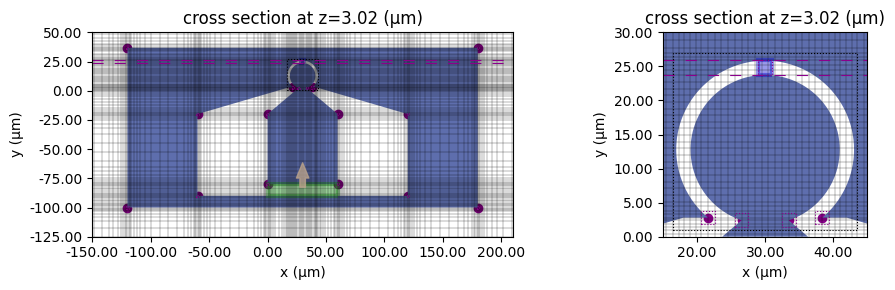

In [14]:
# Metal electrode plane
fig, ax = plt.subplots(1, 2, figsize=(10, 3), tight_layout=True)
tcm.simulation.plot_grid(z=bounds_electrode[1], ax=ax[0])
tcm.plot_sim(z=bounds_electrode[1], ax=ax[0], monitor_alpha=0, hlim=(-150, 210), vlim=(-125, 50))
tcm.simulation.plot_grid(z=bounds_electrode[0], ax=ax[1])
tcm.plot_sim(z=bounds_electrode[1], ax=ax[1], monitor_alpha=0, hlim=(15, 45), vlim=(0, 30))
plt.show()

We can also use the 3D viewer. 

In [15]:
sim.plot_3d()

## Running the Simulation

The simulation is executed below. 

In [16]:
tcm_data = web.run(tcm, task_name="microring_electrode", path="data/microring_electrode.hdf5")

15:29:00 EST Created task 'microring_electrode' with resource_id                
             'sid-6857c885-b3a5-4037-9712-a7d128ef7ec5' and task_type           
             'TERMINAL_CM'.

             View task using web UI at                                          
             ]8;id=984133;https://tidy3d.simulation.cloud/rf?taskId=pa-f69572f7-2ab1-4c96-bd5b-1574ec339f7e\'https://tidy3d.simulation.cloud/rf?]8;;\]8;id=150179;https://tidy3d.simulation.cloud/rf?taskId=pa-f69572f7-2ab1-4c96-bd5b-1574ec339f7e\taskId]8;;\]8;id=984133;https://tidy3d.simulation.cloud/rf?taskId=pa-f69572f7-2ab1-4c96-bd5b-1574ec339f7e\=]8;;\]8;id=584908;https://tidy3d.simulation.cloud/rf?taskId=pa-f69572f7-2ab1-4c96-bd5b-1574ec339f7e\pa]8;;\]8;id=984133;https://tidy3d.simulation.cloud/rf?taskId=pa-f69572f7-2ab1-4c96-bd5b-1574ec339f7e\-f69572f7-2ab1-4c96-bd]8;;\
             ]8;id=984133;https://tidy3d.simulation.cloud/rf?taskId=pa-f69572f7-2ab1-4c96-bd5b-1574ec339f7e\5b-1574ec339f7e']8;;\.

             Task folder: ]8;id=152427;https://tidy3d.simulation.cloud/folders/f89aec3e-3357-4624-9c24-096a87582f12\'default']8;;\.

Output()

15:29:08 EST Maximum FlexCredit cost: 0.113. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' after run.

             Subtasks status - microring_electrode                              
             Group ID: 'pa-f69572f7-2ab1-4c96-bd5b-1574ec339f7e'

Output()

             Batch status = preprocess

15:29:15 EST Batch status = running

15:49:14 EST Batch status = postprocess

15:49:27 EST Modeler has finished running successfully.

             Billed flex credit cost: 0.059.

Output()

15:49:29 EST Loading component modeler data from data/microring_electrode.hdf5

## Results

### S-parameter

We extract S11 below. For comparison purposes, we also import benchmark data from a commercial FEM solver based on a similar setup.

In [17]:
# Extract S11
smat = tcm_data.smatrix().data
S11 = np.conjugate(smat.squeeze())

# Import benchmark data
freqs_ben, S11dB_ben = np.genfromtxt(
    "misc/mrr_fem_sparam.csv", delimiter=",", skip_header=1, unpack=True
)

The return loss (RL) is shown below. We find very good agreement with the benchmark. From the RL plot, we observe that the electrode has a -3 dB bandwidth of up to 55 GHz. 

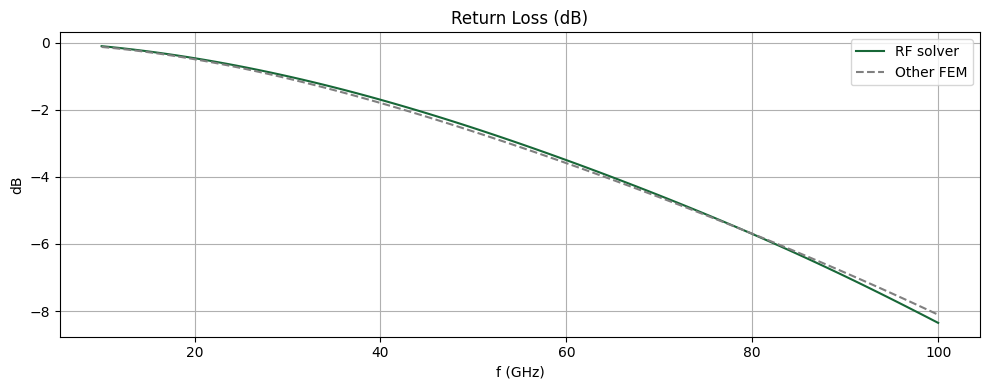

In [18]:
# Plot return loss
fig, ax = plt.subplots(figsize=(10, 4), tight_layout=True)
ax.plot(freqs / 1e9, 20 * np.log10(np.abs(S11)), label="RF solver")
ax.plot(freqs_ben, S11dB_ben, ls="--", color="gray", label="Other FEM")
ax.set_title("Return Loss (dB)")
ax.set_ylabel("dB")
ax.set_xlabel("f (GHz)")
ax.grid()
ax.legend()
plt.show()

### Field profile

We extract the field monitor data and plot the in-plane field magnitude at the center frequency below. 

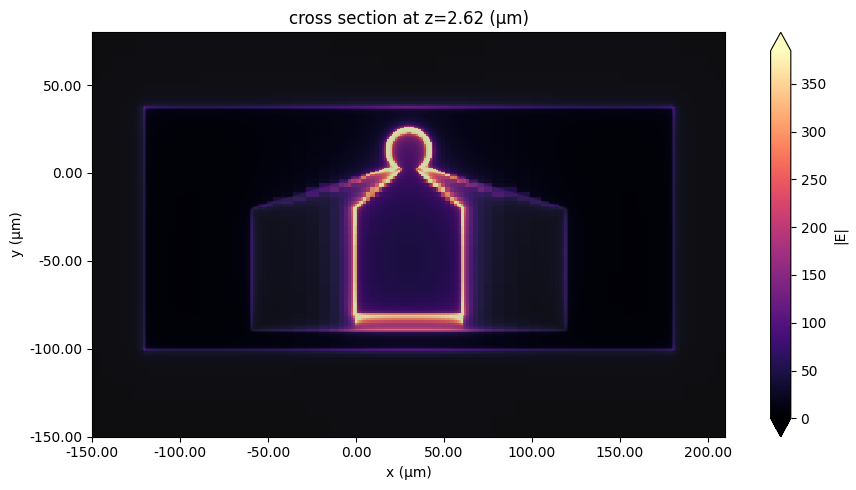

In [19]:
# Extract monitor data
sim_data = tcm_data.data["LP1"]

# Plot field monitor data
fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)
f_plot = f0
sim_data.plot_field("field in-plane", field_name="E", val="abs", f=f_plot, ax=ax)
ax.set_xlim(-150, 210)
ax.set_ylim(-150, 80)
plt.show()

## Reference

[1] Wang, Zhao. "Silicon micro-ring resonator modulator for inter/intra-data centre applications." PhD diss., 2017.